## Adversarial Autoencoders


**Submitted by** -Abhishek Selokar

**ID** 21MM62R10

## Import Headers

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms,datasets
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt
import time
from torch import autograd
plt.style.use('default')

## Loading MNIST dataset

In [2]:
transform =  transforms.ToTensor()


trainset = datasets.MNIST(root='./MNIST', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True) # Creating dataloader
testset = datasets.MNIST(root='./MNIST', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



## Training and testing samples

In [3]:
print('No. of samples in train set: '+str(len(train_loader.dataset)))
print('No. of samples in test set: '+str(len(test_loader.dataset)))

No. of samples in train set: 60000
No. of samples in test set: 10000


Iter for iterating through dataset

In [4]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [5]:
def to_np(x):
    return x.data.cpu().numpy()

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [6]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Creating model for Encoder,Decoder and Discriminator

In [7]:
#Encoder
class Q_net(nn.Module):  
    def __init__(self,X_dim,N,z_dim):
        super(Q_net, self).__init__()
        self.lin1 = nn.Linear(X_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3gauss = nn.Linear(N, z_dim)
    def forward(self, x):
        x = F.dropout(self.lin1(x))
        x = F.relu(x)
        x = F.dropout(self.lin2(x))
        x = F.relu(x)
        xgauss = self.lin3gauss(x)
        return xgauss
    
# Decoder
class P_net(nn.Module):  
    def __init__(self,X_dim,N,z_dim):
        super(P_net, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, X_dim)
    def forward(self, x):
        x = F.dropout(self.lin1(x))
        x = F.relu(x)
        x = F.dropout(self.lin2(x))
        x = self.lin3(x)
        return torch.sigmoid(x)
    
# Discriminator
class D_net_gauss(nn.Module):  
    def __init__(self,N,z_dim):
        super(D_net_gauss, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, 2)
    def forward(self, x):
        x = F.dropout(self.lin1(x))
        x = F.relu(x)
        x = F.dropout(self.lin2(x))
        x = F.relu(x)
        return torch.sigmoid(self.lin3(x))     

In [8]:
EPS = 1e-15
z_red_dims = 2
encoder = Q_net(784,1000,z_red_dims).to(device)
decoder = P_net(784,1000,z_red_dims).to(device)
Disc = D_net_gauss(500,z_red_dims).to(device)


Parameters to be used


In [9]:
# Set learning rates
gen_lr = 0.0001
reg_lr = 0.00005


#epochs
num_epochs=90

## ***Adam*** ***Optimizer***

In [10]:
#encode/decode optimizers
optim_decoder = torch.optim.Adam(decoder.parameters(), lr=gen_lr)
optim_encoder = torch.optim.Adam(encoder.parameters(), lr=gen_lr)
#regularizing optimizers
optim_encoder_reg = torch.optim.Adam(encoder.parameters(), lr=reg_lr)
optim_D1 = torch.optim.Adam(Disc.parameters(), lr=reg_lr)

## Training For ***MSE*** loss

In [11]:
ae_criterion1 = nn.MSELoss()
# num_epochs = 100
train_loss1 = []
disc_loss1=[]
train_acc1 = []
outputs = []

def training(encoder, decoder, Disc, dataloader, optim_encoder, optim_decoder, optim_D,ae_criterion, train):
    total_rec_loss = 0
    total_disc_loss = 0
    total_gen_loss = 0
    if train:
        encoder.train()
        decoder.train()
        Disc.train()
    else:
        encoder.eval()
        decoder.eval()
        Disc.eval()

    for i, (data, labels) in enumerate(dataloader):
        """ Reconstruction loss """
        for p in Disc.parameters():
            p.requires_grad = False

        real_data_v = autograd.Variable(data).to(device)
        real_data_v = real_data_v.view(-1, 784).to(device)
        #print(real_data_v.size())
        encoding = encoder(real_data_v).to(device)
        fake = decoder(encoding).to(device)
        ae_loss = ae_criterion(fake, real_data_v)
        total_rec_loss += ae_loss.item()
        if train:
            optim_encoder.zero_grad()
            optim_decoder.zero_grad()
            ae_loss.backward()
            optim_encoder.step()
            optim_decoder.step()

        """ Discriminator loss """
        encoder.eval()
        z_real_gauss = autograd.Variable(torch.randn(data.size()[0], 2) * 5.).to(device)
        D_real_gauss = Disc(z_real_gauss)

        z_fake_gauss = encoder(real_data_v)
        D_fake_gauss = Disc(z_fake_gauss)

        D_loss = -torch.mean(torch.log(D_real_gauss + EPS) + torch.log(1 - D_fake_gauss + EPS))
        total_disc_loss += D_loss.item()

        if train:
            optim_D.zero_grad()
            D_loss.backward()
            optim_D.step()

        """ Generator loss """
        if train:
            encoder.train()
        else:
            encoder.eval()
        z_fake_gauss = encoder(real_data_v)
        D_fake_gauss = Disc(z_fake_gauss)

        G_loss = -torch.mean(torch.log(D_fake_gauss + EPS))
        total_gen_loss += G_loss.item()

        if train:
            optim_encoder_reg.zero_grad()
            G_loss.backward()
            optim_encoder_reg.step()


        if i % 500 == 0:
            print ('\n Step [%d], recon_loss: %.4f, discriminator_loss :%.4f , generator_loss:%.4f'
                    %(i, ae_loss.item(), D_loss.item(), G_loss.item()))
            outputs.append((epoch, data, fake))

    M = len(dataloader.dataset)
    return total_rec_loss /M  , total_disc_loss /M , total_gen_loss /M


In [12]:
for epoch in range(num_epochs):
    l1,l2 ,l3 = training(encoder, decoder, Disc, train_loader, optim_encoder, optim_decoder, optim_D1,ae_criterion1, True)
    print('\n epoch:{} ---- training loss:{}'.format((epoch+1), l1))
    train_loss1.append(l1)
    disc_loss1.append(l2)
MSE_recon_acc=[100-a*100 for a in train_loss1]
MSE_discr_acc=[100-a*100 for a in disc_loss1]


 Step [0], recon_loss: 0.2326, discriminator_loss :1.5439 , generator_loss:0.7288

 Step [500], recon_loss: 0.0570, discriminator_loss :1.5399 , generator_loss:0.6941

 epoch:1 ---- training loss:0.0009706290410210689

 Step [0], recon_loss: 0.0564, discriminator_loss :1.5561 , generator_loss:0.7094

 Step [500], recon_loss: 0.0500, discriminator_loss :1.5388 , generator_loss:0.7145

 epoch:2 ---- training loss:0.0008130203961705168

 Step [0], recon_loss: 0.0500, discriminator_loss :1.5816 , generator_loss:0.7103

 Step [500], recon_loss: 0.0475, discriminator_loss :1.6181 , generator_loss:0.6988

 epoch:3 ---- training loss:0.0007855205950637659

 Step [0], recon_loss: 0.0523, discriminator_loss :1.5385 , generator_loss:0.7188

 Step [500], recon_loss: 0.0502, discriminator_loss :1.5693 , generator_loss:0.6952

 epoch:4 ---- training loss:0.0007710170060396195

 Step [0], recon_loss: 0.0513, discriminator_loss :1.5240 , generator_loss:0.7021

 Step [500], recon_loss: 0.0468, discrim

In [13]:
len(train_loss1)

90

## *Q1: Plot a sample of generated image and real image for all 0-9 digits.*

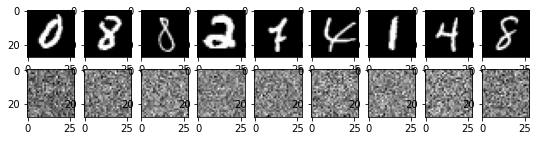

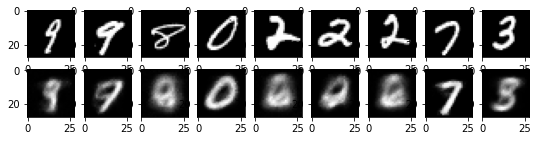

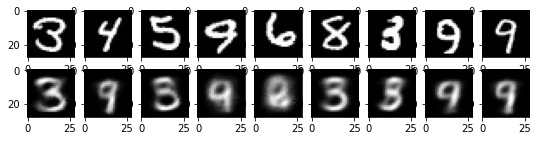

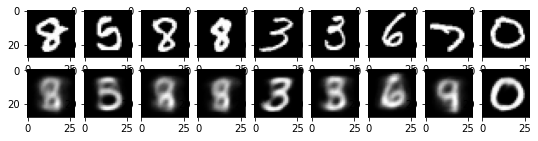

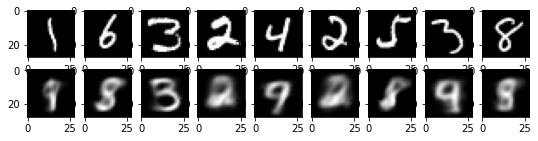

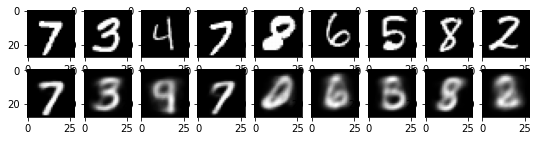

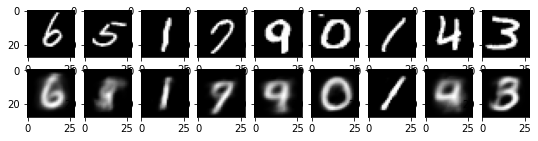

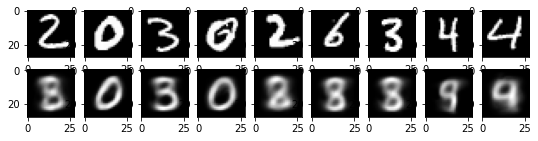

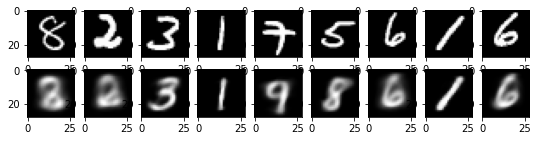

In [14]:
for k in range(0,num_epochs,10):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

# Plotting MSE loss and Accuracy

Text(0, 0.5, 'Discrminator MSE accuracy')

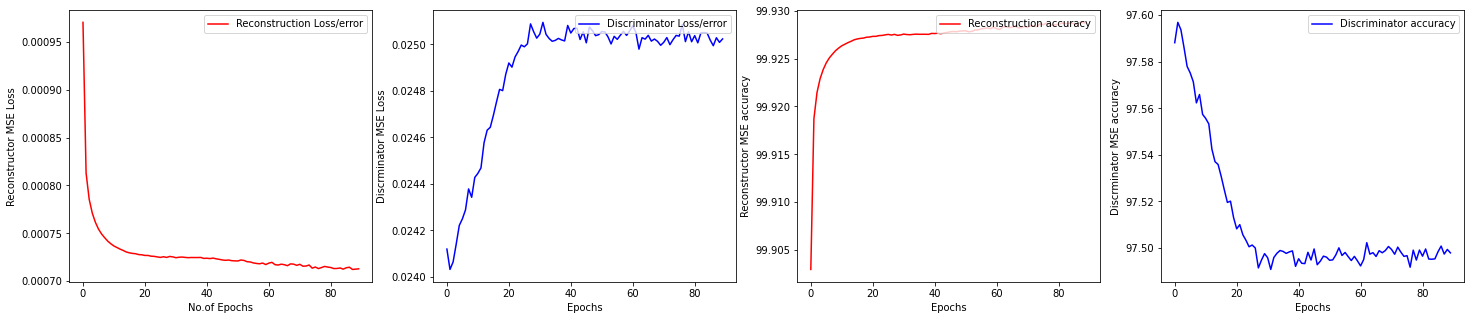

In [15]:
fig = plt.figure(figsize=[25,5]) 
plt.subplot(141)
plt.plot(range(num_epochs),train_loss1,'r-',label='Reconstruction Loss/error') 
plt.legend(loc='upper right')
plt.xlabel('No.of Epochs')
plt.ylabel('Reconstructor MSE Loss')
plt.subplot(142)
plt.plot(range(num_epochs),disc_loss1,'b-',label='Discriminator Loss/error') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Discrminator MSE Loss')
plt.subplot(143)
plt.plot(range(num_epochs),MSE_recon_acc,'r-',label='Reconstruction accuracy') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Reconstructor MSE accuracy')
plt.subplot(144)
plt.plot(range(num_epochs),MSE_discr_acc,'b-',label='Discriminator accuracy') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Discrminator MSE accuracy')

# Training for BCE loss

In [16]:
ae_criterion1 = nn.BCELoss()
# num_epochs = 100
train_loss2 = []
disc_loss2=[]
train_acc2 = []
outputs2 = []

for epoch in range(num_epochs):
    l1,l2 ,l3 = training(encoder, decoder, Disc, train_loader, optim_encoder, optim_decoder, optim_D1,ae_criterion1, True)
    print('\n epoch:{} ---- training loss:{}'.format((epoch+1), l1))
    train_loss2.append(l1)
    disc_loss2.append(l2)



 Step [0], recon_loss: 0.1973, discriminator_loss :1.6789 , generator_loss:0.6681

 Step [500], recon_loss: 0.1932, discriminator_loss :1.6459 , generator_loss:0.6674

 epoch:1 ---- training loss:0.0031210317765673003

 Step [0], recon_loss: 0.2012, discriminator_loss :1.6044 , generator_loss:0.6555

 Step [500], recon_loss: 0.1979, discriminator_loss :1.5930 , generator_loss:0.6908

 epoch:2 ---- training loss:0.0031021631220976512

 Step [0], recon_loss: 0.1987, discriminator_loss :1.5872 , generator_loss:0.7002

 Step [500], recon_loss: 0.2041, discriminator_loss :1.5421 , generator_loss:0.6751

 epoch:3 ---- training loss:0.0031039602962632975

 Step [0], recon_loss: 0.1873, discriminator_loss :1.6172 , generator_loss:0.6667

 Step [500], recon_loss: 0.1899, discriminator_loss :1.5494 , generator_loss:0.6751

 epoch:4 ---- training loss:0.0031013776525855062

 Step [0], recon_loss: 0.2051, discriminator_loss :1.6575 , generator_loss:0.6693

 Step [500], recon_loss: 0.1954, discrim

In [17]:
BCE_recon_acc=[100-a*100 for a in train_loss2]
BCE_discr_acc=[100-a*100 for a in disc_loss2]

# **Plotting BCE loss and Accuracy**

Text(0, 0.5, 'Discrminator BCE accuracy')

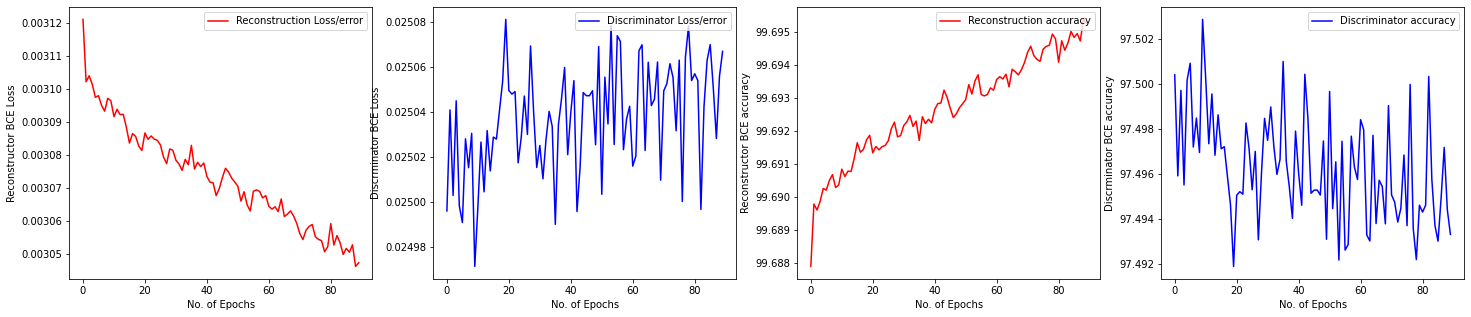

In [18]:
fig = plt.figure(figsize=[25,5]) 
plt.subplot(141)
plt.plot(range(num_epochs),train_loss2,'r-',label='Reconstruction Loss/error') 
plt.legend(loc='upper right')
plt.xlabel('No. of Epochs')
plt.ylabel('Reconstructor BCE Loss')
plt.subplot(142)
plt.plot(range(num_epochs),disc_loss2,'b-',label='Discriminator Loss/error') 
plt.legend(loc='upper right')
plt.xlabel('No. of Epochs')
plt.ylabel('Discrminator BCE Loss')
plt.subplot(143)
plt.plot(range(num_epochs),BCE_recon_acc,'r-',label='Reconstruction accuracy') 
plt.legend(loc='upper right')
plt.xlabel('No. of Epochs')
plt.ylabel('Reconstructor BCE accuracy')
plt.subplot(144)
plt.plot(range(num_epochs),BCE_discr_acc,'b-',label='Discriminator accuracy') 
plt.legend(loc='upper right')
plt.xlabel('No. of Epochs')
plt.ylabel('Discrminator BCE accuracy')

# **Function for SSIM loss**

In [19]:
  # def SSIM(img1,img2,window: int=11, pad="same",):
  #   C1,C2=1,1
  #   channels, height, width = img1.size()
  #   mu1 = F.conv2d(img1, window, padding=pad, groups=channels)
  #   mu2 = F.conv2d(img2, window, padding=pad, groups=channels)
  #   mu1_sq = mu1 ** 2
  #   mu2_sq = mu2 ** 2
  #   mu12 = mu1 * mu2

  #   sigma1_sq = F.conv2d(img1 * img1, window, padding=pad, groups=channels) - mu1_sq
  #   sigma2_sq = F.conv2d(img2 * img2, window, padding=pad, groups=channels) - mu2_sq
  #   sigma12 =  F.conv2d(img1 * img2, window, padding=pad, groups=channels) - mu12

  #   contrast_metric = (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)
  #   contrast_metric = torch.mean(contrast_metric)

  #   numerator1 = 2 * mu12 + C1
  #   numerator2 = 2 * sigma12 + C2
  #   denominator1 = mu1_sq + mu2_sq + C1
  #   denominator2 = sigma1_sq + sigma2_sq + C2
  #   ssim_score = (numerator1 * numerator2) / (denominator1 * denominator2)
  #   return ssim_score.mean()

In [20]:
pip install piqa

# Training for SSIM **loss** 

In [21]:

from piqa import SSIM

class SSIMLoss(SSIM):
    def forward(self, x, y):
        return 1. - super().forward(x, y)

ae_criterion = SSIMLoss().cuda() #if you need GPU support
# loss = criterion(x, y)


In [22]:
## Module: pytorch_ssim.SSIM(window_size = 11, size_average = True)
# ae_criterion1  = pytorch_ssim.SSIM()
# ae_criterion1 = nn.SSIMLoss()
# num_epochs = 100
train_loss3 = []
disc_loss3=[]
train_acc3 = []
outputs3 = []

for epoch in range(num_epochs):
    l1,l2 ,l3 = training(encoder, decoder, Disc, train_loader, optim_encoder, optim_decoder, optim_D1,ae_criterion1, True)
    print('\n epoch:{} ---- training loss:{}'.format((epoch+1), l1))
    train_loss3.append(l1)
    disc_loss3.append(l2)


 Step [0], recon_loss: 0.2007, discriminator_loss :1.6186 , generator_loss:0.6656

 Step [500], recon_loss: 0.1873, discriminator_loss :1.6488 , generator_loss:0.6867

 epoch:1 ---- training loss:0.0030485065199434757

 Step [0], recon_loss: 0.1898, discriminator_loss :1.5745 , generator_loss:0.6434

 Step [500], recon_loss: 0.1942, discriminator_loss :1.5676 , generator_loss:0.6874

 epoch:2 ---- training loss:0.003047900937249263

 Step [0], recon_loss: 0.2016, discriminator_loss :1.6477 , generator_loss:0.6644

 Step [500], recon_loss: 0.1918, discriminator_loss :1.6305 , generator_loss:0.6615

 epoch:3 ---- training loss:0.003049428384999434

 Step [0], recon_loss: 0.1945, discriminator_loss :1.6765 , generator_loss:0.6642

 Step [500], recon_loss: 0.1926, discriminator_loss :1.6348 , generator_loss:0.6603

 epoch:4 ---- training loss:0.003050476089864969

 Step [0], recon_loss: 0.1974, discriminator_loss :1.5856 , generator_loss:0.6806

 Step [500], recon_loss: 0.1958, discrimina

In [23]:
SSIM_recon_acc=[100-a*100 for a in train_loss3]
SSIM_discr_acc=[100-a*100 for a in disc_loss3]

# **Plotting SSIM loss and Accuracy**

Text(0, 0.5, 'Discrminator SSIM accuracy')

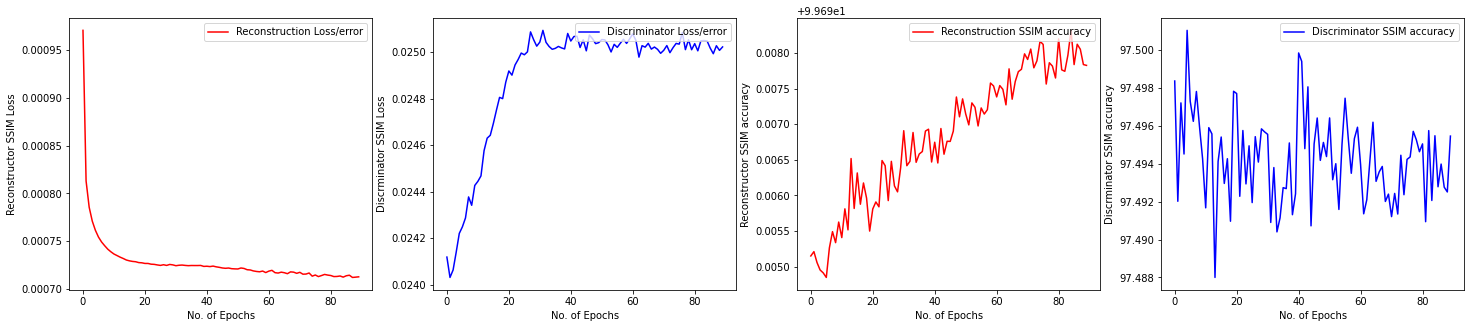

In [24]:
fig = plt.figure(figsize=[25,5]) 
plt.subplot(141)
plt.plot(range(num_epochs),train_loss1,'r-',label='Reconstruction Loss/error') 
plt.legend(loc='upper right')
plt.xlabel('No. of Epochs')
plt.ylabel('Reconstructor SSIM Loss')
plt.subplot(142)
plt.plot(range(num_epochs),disc_loss1,'b-',label='Discriminator Loss/error') 
plt.legend(loc='upper right')
plt.xlabel('No. of Epochs')
plt.ylabel('Discrminator SSIM Loss')
plt.subplot(143)
plt.plot(range(num_epochs),SSIM_recon_acc,'r-',label='Reconstruction SSIM accuracy') 
plt.legend(loc='upper right')
plt.xlabel('No. of Epochs')
plt.ylabel('Reconstructor SSIM accuracy')
plt.subplot(144)
plt.plot(range(num_epochs),SSIM_discr_acc,'b-',label='Discriminator SSIM accuracy') 
plt.legend(loc='upper right')
plt.xlabel('No. of Epochs')
plt.ylabel('Discrminator SSIM accuracy')


### Q3) Write the entire training process of the vanilla adversarial autoencoder in brief and con-cise3-5 step algorithm.

Ans - the training process of the Adversarial autoencoder is quite similar to GAN and is carried out in following way

1. Firstly the encoder and decoder part of whole AAE is trained to reduce recontruction loss. 
    At this stage the Generator and Discriminator are neglected.
   Then pass input to encoder which will result in a latent code and now this latent code will be fed to decoder .Using    Backpropgation weights will be updated such that recontruction loss get decreased


2. Unlike first part now train only Generator and Discrimaintor leaving the decoder untouched.Train the discriminator to classify the output from the genrator having required distributiuion and the encoder part .
Upon training now our discriminator will learn to classify real images from generator and fake images from Encoder

3. Now by connecting the encoder output  to the discriminator input we will make sure that encoder learns the same distribution as that of the generator which had required distriibution to produce real images

4. Fix the  discriminator weights and target value as 1 (real image) and feed image to encoder and find discriminator output.We will backpropgate only through the encopdcder to update weights of only encoder so that it lresarns the desired distribution and produce output  which will have that diostribution 




#### Algorithm:

1.Train Encoder and Decoder with optimizer and loss

2.Fix weights of Decoder and train  discriminator, generator (with desirted distribution) and encoder

3.Connect Encoder output to Discrtiminator input and train it keeping the discrimantor weights constant and target value as 1 (real image)

4.Now Encoder too learns the required distribtuion to generate fake images exacttly similar to real images

5.Plot Accuracy and Loss results  

# *Plot the training accuracy and loss values for all the 3 loss functions as 2 separate plots.*

Text(0, 0.5, 'Discriminant Accuracy')

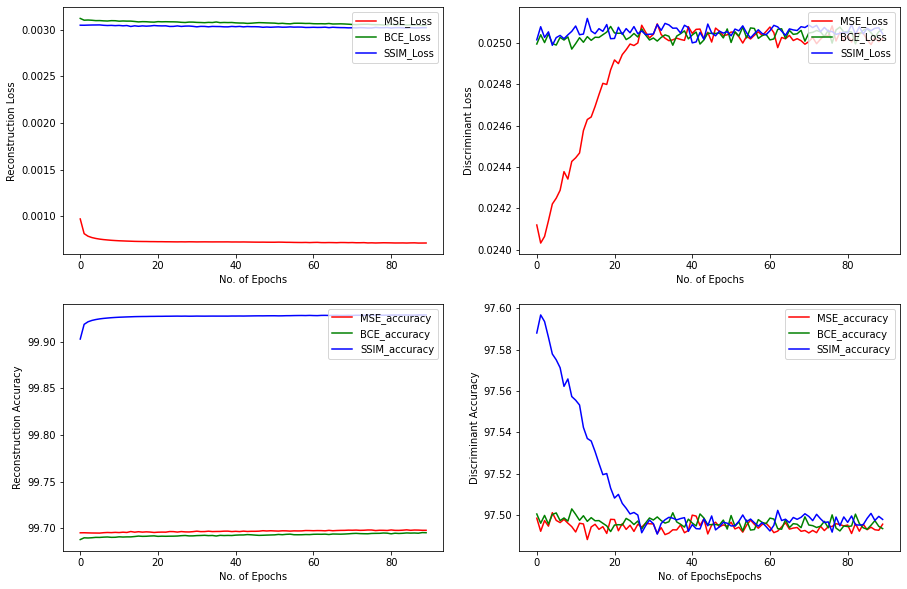

In [31]:
fig = plt.figure(figsize=[15,10]) 
plt.subplot(2,2,1)
plt.plot(range(num_epochs),train_loss1,'r-',label='MSE_Loss') 
plt.plot(range(num_epochs),train_loss2,'g-',label='BCE_Loss') 
plt.plot(range(num_epochs),train_loss3,'b-',label='SSIM_Loss') 
plt.legend(loc='upper right')
plt.xlabel('No. of Epochs')
plt.ylabel('Reconstruction Loss')

plt.subplot(2,2,2)
plt.plot(range(num_epochs),disc_loss1,'r-',label='MSE_Loss') 
plt.plot(range(num_epochs),disc_loss2,'g-',label='BCE_Loss') 
plt.plot(range(num_epochs),disc_loss3,'b-',label='SSIM_Loss') 
plt.legend(loc='upper right')
plt.xlabel('No. of Epochs')
plt.ylabel('Discriminant Loss')

plt.subplot(2,2,3)
plt.plot(range(num_epochs),SSIM_recon_acc,'r-',label='MSE_accuracy') 
plt.plot(range(num_epochs),BCE_recon_acc,'g-',label='BCE_accuracy') 
plt.plot(range(num_epochs),MSE_recon_acc,'b-',label='SSIM_accuracy') 
plt.legend(loc='upper right')
plt.xlabel('No. of Epochs')
plt.ylabel('Reconstruction Accuracy')

plt.subplot(2,2,4)
plt.plot(range(num_epochs),SSIM_discr_acc,'r-',label='MSE_accuracy') 
plt.plot(range(num_epochs),BCE_discr_acc,'g-',label='BCE_accuracy') 
plt.plot(range(num_epochs),MSE_discr_acc,'b-',label='SSIM_accuracy') 
plt.legend(loc='upper right')
plt.xlabel('No. of EpochsEpochs')
plt.ylabel('Discriminant Accuracy')

### Q5.) Based on the plots in Q4, provide your comments on which of the suggested loss functions is best for the current task and why?  

Ans -As we can observe from the above graphs that out of all three losses i.e. MSE,SSIM and BCE, with MSE Loss we are getting the maximum reconstruction accuracy and minimum discriminant accuracy. So, MSE loss is the best loss function for the current task(AAE model on MNIST dataset). And if we are look at the graphs of SSIM and BCE loss function, there are fluctuation with the increasing number of epochs and at the end also,the accuracy is less. But on the other hand, MSE accuray is continously increasing and and also the maximum.  